In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

# Get Data

In [2]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()
data_s = data["S"]

# Create Returns and Directional Movement
data_s["ret"] = data_s["close"].pct_change()
data_s.dropna(axis = 0 , inplace = True)
data_s["dir"] = data_s["ret"].apply(lambda x: 1 if x >= 0  else 0)

display(data_s.head())

,open,high,low,close,volume,ret,dir
date,,,,,,,
2012-12-28,140.64,141.42,139.87,140.03,148806700.0,-0.016712,0
2012-12-27,141.79,142.08,139.92,141.56,167920600.0,0.010926,1
2012-12-26,142.64,142.71,141.35,141.75,106947700.0,0.001342,1
2012-12-24,142.48,142.56,142.19,142.35,53874600.0,0.004233,1
2012-12-21,142.17,144.09,141.94,142.79,245883800.0,0.003091,1


# Beta Bernoulli Model

In [3]:
np.random.seed(123)

with pm.Model() as betabern:
    # a priori
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_s["dir"])
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 1725.89draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.459,0.03,0.401,0.515,0.001,0.001,787.0,785.0,782.0,1429.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x126c91ad0>],
      dtype=object)

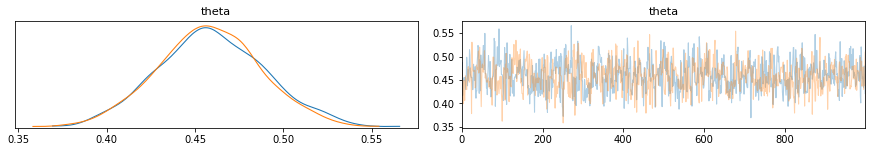

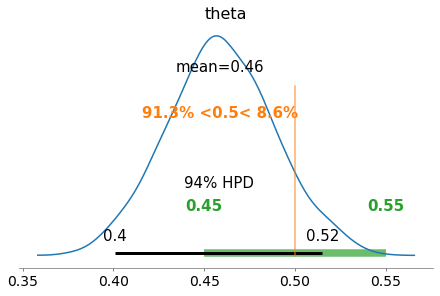

In [4]:
display(az.summary(trace))
az.plot_trace(trace)
az.plot_posterior(trace ,  ref_val=0.5 , rope=[0.45, .55])

# Gaussian Inference

In [5]:
with pm.Model() as gaussian:
    mu = pm.Uniform('mu', lower=-1, upper=1)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data_s["ret"])
    trace_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 999.13draws/s] 
The acceptance probability does not match the target. It is 0.8817807394285195, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9070112742608031, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.000,0.001,-0.001,0.001,0.0,0.0,1722.0,1056.0,1737.0,1127.0,1.0
sigma,0.008,0.000,0.007,0.009,0.0,0.0,1694.0,1694.0,1682.0,1156.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126785710>,
      dtype=object)

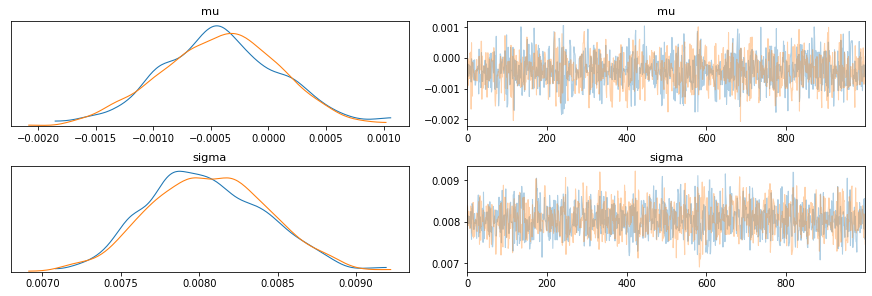

In [6]:
# Some Diagnostics
display(az.summary(trace_g))
az.plot_trace(trace_g)

100%|██████████| 100/100 [00:00<00:00, 418.68it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


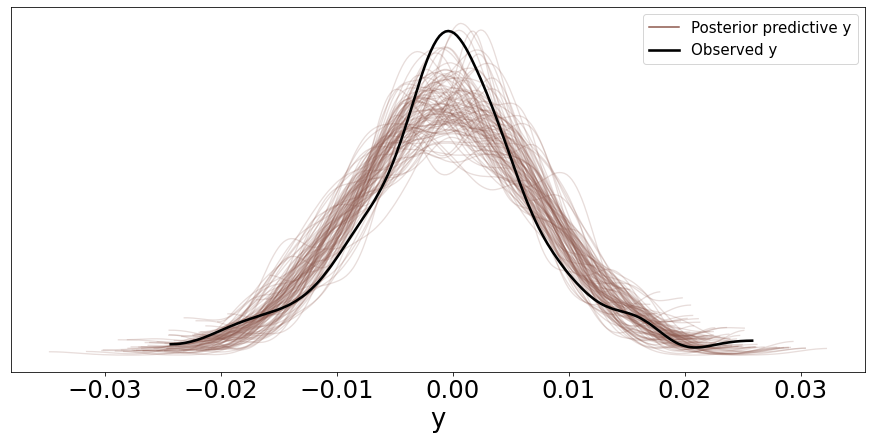

In [7]:
# Posterior Predictive Checks
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, gaussian)
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

# Simulate Custom Posterior

In [80]:
custom_pred = np.zeros([100, len(trace_g)])
custom_pred[:] - np.nan
for i in range(len(trace_g)):
    custom_pred[:,i] = stats.norm(trace_g[i]["mu"],trace_g[i]["sigma"]).rvs(100)


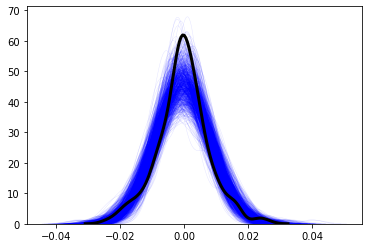

In [92]:
for i in range(len(trace_g)):
    sns.kdeplot(custom_pred[:,i] , color = "blue", linewidth = 0.5 , alpha=0.1)
sns.kdeplot(data_s["ret"].values, color = "black", linewidth = 3.0)

# Student Inference

In [8]:
with pm.Model() as student:
    mu = pm.Uniform('mu', -1, 1)
    sigma = pm.HalfNormal('sigma', sd=10)
    dof = pm.Exponential('dof', 1/30)
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=dof, observed=data_s["ret"])
    trace_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dof, sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:08<00:00, 352.72draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.000,0.000,-0.001,0.000,0.000,0.000,963.0,919.0,963.0,897.0,1.0
sigma,0.007,0.001,0.006,0.008,0.000,0.000,810.0,810.0,812.0,870.0,1.0
dof,11.917,12.549,2.368,33.371,0.442,0.313,806.0,806.0,776.0,943.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a7cbd10>,
      dtype=object)

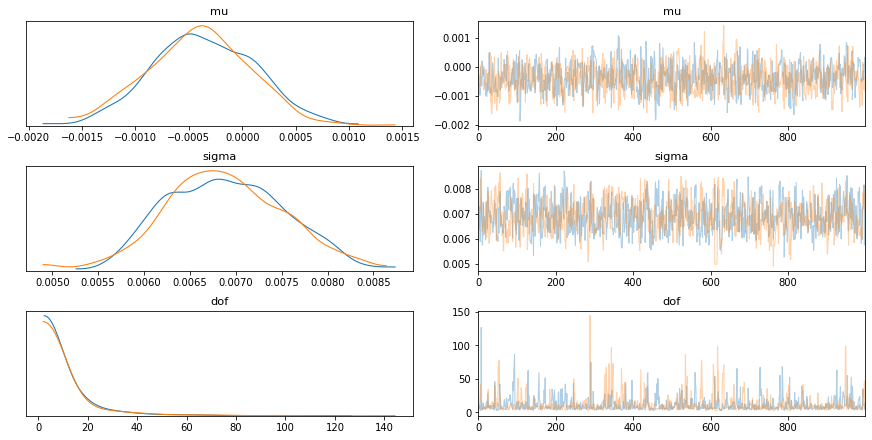

In [9]:
# Some Diagnostics
display(az.summary(trace_t))
az.plot_trace(trace_t)


100%|██████████| 100/100 [00:00<00:00, 493.11it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


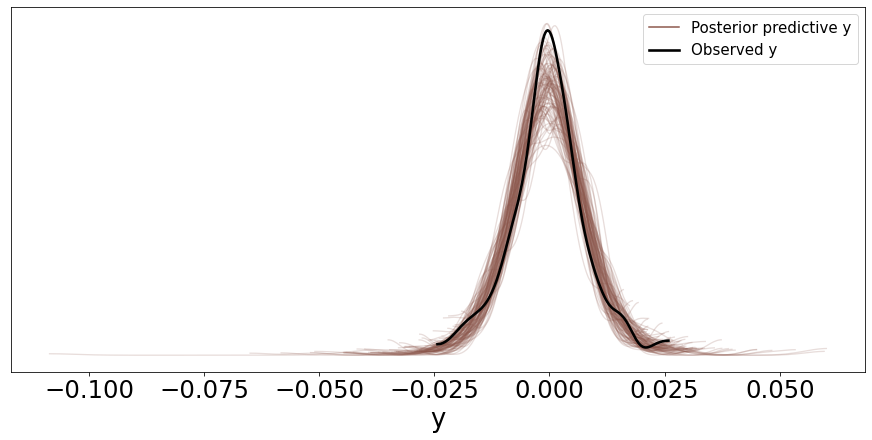

In [10]:
# Posterior Predictive Checks
y_pred_t = pm.sample_posterior_predictive(trace_t, 100, student)
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=y_pred_t)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)